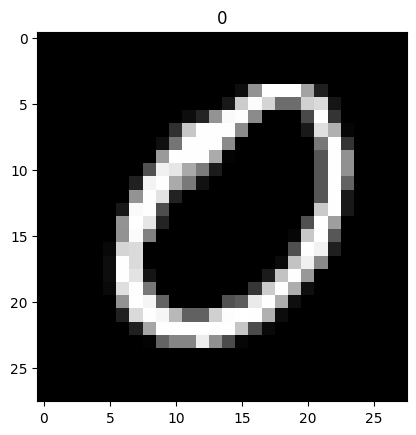

In [10]:
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time
from math import ceil

from numpy import typing as npt

def load_images(path_to_images):
    images = np.fromfile(path_to_images, dtype=np.uint8, count= -1)[16:]
    return images

def reshape_images(images):
    return images.reshape(-1, 28, 28)

def load_labels(path_to_labels):
    labels = np.fromfile(path_to_labels, dtype=np.uint8, count=-1)[8:]
    return labels

training_images_filepath = "./train-images.idx3-ubyte"
training_labels_filepath = "./train-labels.idx1-ubyte"

test_images_filepath = "./t10k-images.idx3-ubyte"
test_labels_filepath = "./t10k-labels.idx1-ubyte"

x_train = load_images(training_images_filepath)
x_test = load_images(test_images_filepath)

y_train = load_labels(training_labels_filepath)
y_test = load_labels(test_labels_filepath)

x_train = reshape_images(x_train)
x_test = reshape_images(x_test)

y_test = np.eye(10)[y_test]
y_train = np.eye(10)[y_train]

item_num = 1090

plt.imshow(x_train[item_num].reshape((28,28)), cmap='gray')
plt.title(f"{np.where(y_train[item_num] == 1)[0][0]}")
plt.show()

In [11]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train = x_train / 255
x_test = x_test / 255

START_LAYER_NEURALS = 28*28
END_LAYER_NEURALS = 10
HIDDEN_LAYER_NEURALS = 300
LEARNING_RATE = 0.1
BATCH_SIZE = 32
EPOCH_COUNT = 20

params = {
    'W1':np.random.randn(START_LAYER_NEURALS, HIDDEN_LAYER_NEURALS) * np.sqrt(1. / HIDDEN_LAYER_NEURALS),
    'b1': np.random.randn(1, HIDDEN_LAYER_NEURALS) * np.sqrt(1. / HIDDEN_LAYER_NEURALS),
    'W2':np.random.randn(HIDDEN_LAYER_NEURALS, END_LAYER_NEURALS) * np.sqrt(1. / END_LAYER_NEURALS),
    'b2': np.random.randn(1, END_LAYER_NEURALS) * np.sqrt(1. / HIDDEN_LAYER_NEURALS),
}

def ReLU(x: npt.NDArray[np.float32]):
    return np.maximum(x, 0)

def ReLU_with_derivative(x: npt.NDArray[np.float32]):
    return x > 0

def softmax(x: npt.NDArray[np.float32], axis: int = -1):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def go_forward(x_train: npt.NDArray[np.float32]):
    params['A0'] = x_train
    params['Z1'] = params['A0'] @ params["W1"] + params['b1']
    params['A1'] = ReLU(params['Z1'])
    params['Z2'] = params['A1'] @ params["W2"] + params['b2']
    params['A2'] = softmax(params['Z2'])
    return params['A2']

def go_backward(y_train: npt.NDArray[np.float32], output: npt.NDArray[np.float32]):
    change_w = {}

    dZ2 = (output - y_train)
    change_w['W2'] = (params['A1'].T) @ dZ2 * 1 / y_train.shape[0]
    change_w['b2'] = np.sum(dZ2) * 1 / y_train.shape[0]

    dZ1 = 1 / y_train.shape[0] * dZ2 @ params['W2'].T * ReLU_with_derivative(params['Z1'])
    change_w['W1'] = params['A0'].T @ (dZ1)
    change_w['b1'] = np.sum(dZ1)

    return change_w

def update_params(change_w: dict[str, npt.NDArray[np.float32]]):
    params["W1"] -= LEARNING_RATE * change_w['W1']
    params["W2"] -= LEARNING_RATE * change_w['W2']
    params["b1"] -= LEARNING_RATE * change_w['b1']
    params["b2"] -= LEARNING_RATE * change_w['b2']

def get_accuracy(predictions: npt.NDArray[np.float32],Y: npt.NDArray[np.float32]):
    return np.sum(predictions == Y) / Y.size

def train(x_train: npt.NDArray[np.float32],y_train: npt.NDArray[np.float32],
        x_val: npt.NDArray[np.float32], y_val: npt.NDArray[np.float32]
):
    start_time = time.time()
    batches_per_ephoch = ceil(x_train.shape[0] / BATCH_SIZE)

    for epoch in range(EPOCH_COUNT):
        output_vector = []
        for batch_index in range(batches_per_ephoch):
            x_current = x_train[BATCH_SIZE * batch_index: BATCH_SIZE * (batch_index + 1)]
            y_current = y_train[BATCH_SIZE * batch_index: BATCH_SIZE * (batch_index + 1)]

            output = go_forward(x_current)
            output_vector.extend(np.argmax(output, axis=1))

            changes = go_backward(y_current, output)
            update_params(changes)

        print("Эпоха:",epoch + 1, "Времени с запуска:",time.time() - start_time, "Точность:", get_accuracy(np.array(output_vector), np.argmax(y_train, axis=1)))

    preds_val = go_forward(x_val)

    print("Test accuracy:", get_accuracy(np.argmax(preds_val, axis=1), np.argmax(y_val, axis=1)))

train(x_train, y_train, x_test, y_test)

Эпоха: 1 Времени с запуска: 2.4935598373413086 Точность: 0.9364833333333333
Эпоха: 2 Времени с запуска: 4.975117921829224 Точность: 0.9731166666666666
Эпоха: 3 Времени с запуска: 7.4386725425720215 Точность: 0.9823166666666666
Эпоха: 4 Времени с запуска: 9.895223379135132 Точность: 0.9877333333333334
Эпоха: 5 Времени с запуска: 12.335771560668945 Точность: 0.9912833333333333
Эпоха: 6 Времени с запуска: 14.80332612991333 Точность: 0.99405
Эпоха: 7 Времени с запуска: 17.233871459960938 Точность: 0.9959833333333333
Эпоха: 8 Времени с запуска: 19.67241907119751 Точность: 0.9970833333333333
Эпоха: 9 Времени с запуска: 22.11096739768982 Точность: 0.9981166666666667
Эпоха: 10 Времени с запуска: 24.558517456054688 Точность: 0.99865
Эпоха: 11 Времени с запуска: 26.993064403533936 Точность: 0.9991
Эпоха: 12 Времени с запуска: 29.42261004447937 Точность: 0.9994166666666666
Эпоха: 13 Времени с запуска: 31.89516568183899 Точность: 0.9995
Эпоха: 14 Времени с запуска: 34.33071422576904 Точность: 0.99